In [1]:
%pylab inline

import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import optim
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision import transforms
from densenet import DenseNet

from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
EPOCH = 2000
BATCH_SIZE = 32
PRINT_TRAINING_INTERVAL = 1000
CUDA = True

# Data

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


to_pil = transforms.ToPILImage()


trainset = CIFAR10('./CIFAR10', train=True,  transform=transform, download=True)
testset  = CIFAR10('./CIFAR10', train=False, transform=transform, download=True)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


train_x = trainset.train_data
train_y = np.array(trainset.train_labels)
test_x = testset.test_data
test_y = np.array(testset.test_labels)

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

Files already downloaded and verified
Files already downloaded and verified
train_x: (50000, 32, 32, 3)
train_y: (50000,)
test_x: (10000, 32, 32, 3)
test_y: (10000,)


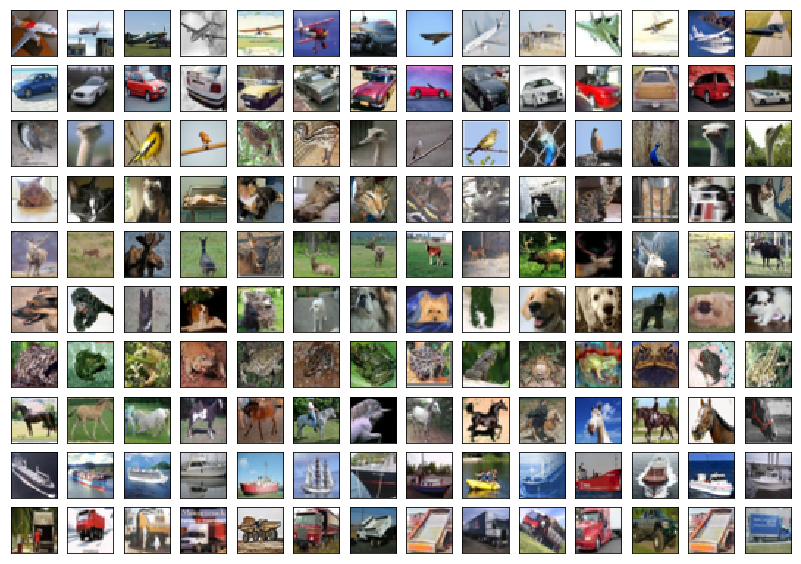

In [4]:
def show_samples(x, y):
    # Convert Tensor to Numpy Array
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy().transpose(0, 2, 3, 1)
        x = (x - x.min()) / (x.max() - x.min())
        x = 1 - x
        x *= 255
        
        x = x.astype('int').astype('float32')
        y = y.cpu().numpy()
    
    x, y = np.array(x), np.array(y)
    labels = np.unique(y)
    
    fig, subplots = pylab.subplots(len(labels), 14, figsize=(14, 10)) # subplots(y축, x축 갯수)
    subplots = subplots.T.reshape(-1)

    for i, p in enumerate(subplots):
        target = x[y == labels[i%len(labels)]]

        idx = np.random.randint(target.shape[0])
        d = target[idx]
        p.get_xaxis().set_visible(False)
        p.get_yaxis().set_visible(False)
        p.imshow(d)
        
show_samples(test_loader.dataset.test_data, test_loader.dataset.test_labels)

## Tools

In [4]:
def evaluate():
    start_t = datetime.now()
    n_total_correct = 0
    total_duration = 0
    N = len(test_loader.dataset)

    for i, (x_sample, y_true) in enumerate(test_loader):
        start_t = datetime.now()
        x_sample, y_true = Variable(x_sample).cuda(), Variable(y_true).cuda()

        y_pred = model(x_sample)
        _, y_pred = torch.max(y_pred.data, 1)
        n_correct = torch.sum(y_pred == y_true.data)
        n_total_correct += n_correct

        # Time
        duration = (datetime.now() - start_t).total_seconds()
        total_duration += duration

#     print(f'[{total_duration/N:<6.2}] accuracy:', n_total_correct/N)
    return n_total_correct/N

def save_model(model, epoch):
    checkpoint = {
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, 'model.pt')

# Model

In [5]:
np.random.seed(0)
model = DenseNet(24, 0.5, n_class=10, fc_size=16320, blocks=[24, 24, 24])
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [7]:
checkpoint = torch.load('model.pt')
model.load_state_dict(checkpoint['model'])

# Train

In [ ]:
logs = {'loss': list(), 'duration': list()}
step = 0

global_test_acc = 0

for epoch in range(0, EPOCH):
    for x_sample, y_sample in train_loader:
        start_t = datetime.now()
        x_sample, y_sample = Variable(x_sample).cuda(), Variable(y_sample).cuda()

        # Init Gradients
        optimizer.zero_grad()

        # Feedforward    
        y_pred = model(x_sample)
        loss = criterion(y_pred, y_sample)
        loss.backward()
        optimizer.step()

        # Add Step
        step += 1

        # Logging
        loss = loss.data.cpu().numpy()[0]
        duration = (datetime.now() - start_t).total_seconds()
        logs['loss'].append(loss)
        logs['duration'].append(duration)
        
        if step % PRINT_TRAINING_INTERVAL == 0:
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            test_acc = evaluate()
            loss = np.mean(logs['loss'][-PRINT_TRAINING_INTERVAL:])
            duration = np.sum(logs['duration'][-PRINT_TRAINING_INTERVAL:])
            print(f'{time} | epoch:{epoch} | step:{step} | loss:{loss:<8.4} | test acc:{test_acc:8.4}')
            
            if test_acc > global_test_acc:
                global_test_acc = test_acc
                save_model(model, epoch)

2017-08-16 09:40:15 | epoch:0 | step:1000 | loss:0.004937 | test acc:   0.886


## Save Model

In [41]:
def save_model(model, epoch):
    checkpoint = {
        'model': model.state_dict()
    }
    torch.save(checkpoint, 'model.pt')

## Evaluate

In [8]:
evaluate()

[0.0035] accuracy: 0.8805


0.8805